In [6]:
# necessary for data import
import xml.etree.ElementTree as ET

import numpy as np

import pickle
import skimage.io as skio


In [1]:
import torch


from skimage.transform import resize

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils


import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt


import skimage as sk

from sklearn.model_selection import train_test_split

import glob

from tqdm import tqdm

In [2]:
import matplotlib.patches as patches

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))


Using cuda device


In [6]:
def display_grid_of_images(array_of_images, array_of_names, w = 6, h = 5, normalize_rgb = False, hide_axes = True):
    num_rows = len(array_of_images)
    num_cols = len(array_of_images[0])
    
    assert len(array_of_names) == num_rows, "same num of rows for names and images"
    
    assert all([len(row) == num_cols for row in array_of_images]), "all rows need to be same length"
    assert all([len(row) == num_cols for row in array_of_names]), "all rows need to be same length for strings too"
    
    fig = plt.figure(figsize=(w * num_cols, h * num_rows))
    subplots = fig.subplots(num_rows, num_cols, squeeze = False)
    
    for row in range(num_rows):
        for col in range(num_cols):
            
            ax = subplots[row, col]
            ax.set_title(array_of_names[row][col])
            pixels = array_of_images[row][col]
            if hide_axes:
                ax.set_axis_off()
            
            if len(pixels.shape) == 2:
                # grayscale (scalars)
                ax.imshow(pixels,cmap='Greys_r')
            if len(pixels.shape) == 3:
                # rgb
                if normalize_rgb:
                    # gotta normalize the rgb ones too!
                    pixels = pixels - np.min(pixels)
                    pixels = pixels / np.max(pixels)
                ax.imshow(pixels)
def display_dictionary_of_images(dic, prefix = '', horiz = False, w = 6, h = 5, normalize_rgb = False, hide_axes = True):
    %matplotlib inline
    
    if horiz:
    
        fig = plt.figure(figsize=(w * len(dic), h))
        try:
            subplots = list(fig.subplots(1, len(dic)))
        except:
            subplots = [fig.subplots(1, len(dic))]
    else:
        fig = plt.figure(figsize=(w, h * len(dic)))
        try:
            subplots = list(fig.subplots(len(dic), 1))
        except:
            subplots = [fig.subplots(len(dic), 1)]
    
    keylist = list(dic.keys())
    
    for i in range(len(dic)):
        key = keylist[i]      
        pixels = dic[key]

        #Display the image
        ax = subplots[i]
        ax.set_title(prefix + ' ' + key)
        if hide_axes:
                ax.set_axis_off()
        if len(pixels.shape) == 2:
            # grayscale (scalars)
            ax.imshow(pixels,cmap='Greys_r')
        if len(pixels.shape) == 3:
            # rgb
            # gotta normalize the rgb ones too!
            if normalize_rgb:
                pixels = pixels - np.min(pixels)
                pixels = pixels / np.max(pixels)
            ax.imshow(pixels)

In [3]:
DATA_PATH = 'data/ibug_300W_large_face_landmark_dataset/'

train_xml_tree = ET.parse(DATA_PATH + 'labels_ibug_300W_train.xml')

train_xml_root = train_xml_tree.getroot()

train_xml_images = train_xml_root[2]

len(train_xml_images)

6666

box: top, left, width, height

In [7]:
all_train_data = []

In [ ]:
for idx in range(len(train_xml_images)):
    
    if idx%300 == 0:
        print(idx)

    curr_image = train_xml_images[idx]

    filename = curr_image.attrib['file']

    img = skio.imread(DATA_PATH + filename)
    
    if len(curr_image) != 1:
        print(len(curr_image))
    
    box_object = curr_image[0]

    box_info = [int(value) for value in box_object.attrib.values()]

    points = np.zeros((68, 2)).astype(int)

    for i in range(68):
        point_object = box_object[i]
        x, y = point_object.attrib['x'], point_object.attrib['y']
        x, y = int(x), int(y)
        points[i] = x, y

    this_datapoint = {
        'image': img,
        'box': box_info,
        'keypoints': points
    }
    
    all_train_data.append(this_datapoint)

0
300
600
900
1200
1500
1800
2100
2400
2700
3000
3300
3600
3900
4200
4500
4800
5100
5400


In [45]:
with open('data/train_data_loaded.pickle', 'wb') as handle:
    pickle.dump(all_train_data, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
# with open('data/train_data_loaded.pickle', 'rb') as handle:
#     all_train_data = pickle.load(handle)


'image', 'box', 'keypoints'

In [63]:
def show_image_with_box_and_points(data_point):
    
    fig = plt.figure(figsize=(8, 10))
    
    ax = fig.subplots()

    ax.imshow(data_point['image'])
    box = data_point['box']
    rect = patches.Rectangle((box[1], box[0]), box[2], box[3], linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    keypoints = data_point['keypoints']
    ax.scatter(*zip(*(keypoints)))

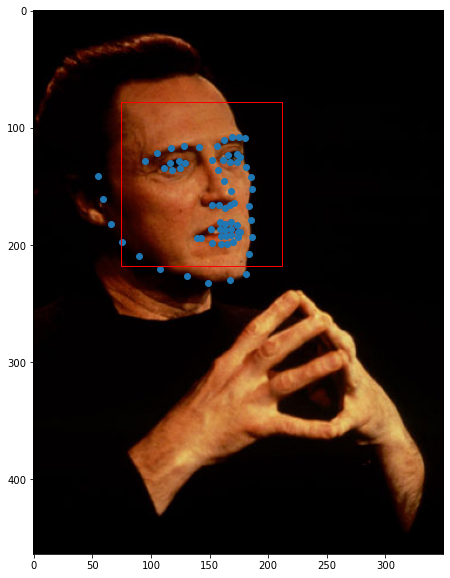

In [70]:
show_image_with_box_and_points(all_train_data[2])

### What's the farthest deviation from the center?

deviation defined as:

$$ \left\{ \left(\max_{keypoints}\frac{abs(midpoint_x - keypoint_x)}{width \; box /2} \right), \left(\max_{keypoints}\frac{abs(midpoint_y - keypoint_y)}{height \; box /2} \right)\right \}$$

Then, if we just expand the boxes by this value, it will encompass all of the keypoints. Then, we can throw awae the rest of the image.

In [ ]:
max_deviation(data):
    # get the max x deviation

In [46]:
all_train_data

[{'image': array([[[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         ...,
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]]], dtype=uint8),
  'box': [78, 74, 138, 140],
  'keypoints': array([[ 55, 141],
         [ 59, 161],
        